In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

sys.path.append("..")

In [89]:
# generating data
from server.optimisation.models import *
from server.optimisation.gen_data import *

def getTicksForDay(id):
    day = Day.model_validate({"day": id, "deferables": getDefDemands(id)})
    ticks = []
    for tick in range(TICKS_PER_DAY):
        sun = getSunlight(tick)
        demand = getInstDemand(id, tick)
        sell, buy = getPrice(id, tick)

        ticks.append(
            Tick.model_validate(
                {
                    "tick": tick,
                    "sun": sun,
                    "demand": demand,
                    "sell_price": sell,
                    "buy_price": buy,
                    "day": id,
                }
            )
        )
    return day, ticks

tick_data = []
for i in range(1700):
    _, tmp = getTicksForDay(143038273)
    tick_data += [tick.buy_price for tick in tmp]

In [90]:
len(tick_data)
tick_data

[11,
 36,
 29,
 26,
 22,
 13,
 15,
 8,
 11,
 31,
 28,
 11,
 33,
 34,
 39,
 53,
 32,
 20,
 46,
 30,
 40,
 25,
 11,
 13,
 17,
 25,
 13,
 12,
 5,
 10,
 5,
 5,
 13,
 6,
 24,
 16,
 9,
 12,
 18,
 35,
 25,
 37,
 36,
 43,
 46,
 45,
 75,
 61,
 47,
 47,
 37,
 51,
 40,
 61,
 43,
 40,
 52,
 31,
 35,
 9,
 11,
 36,
 29,
 26,
 22,
 13,
 15,
 8,
 11,
 31,
 28,
 11,
 33,
 34,
 39,
 53,
 32,
 20,
 46,
 30,
 40,
 25,
 11,
 13,
 17,
 25,
 13,
 12,
 5,
 10,
 5,
 5,
 13,
 6,
 24,
 16,
 9,
 12,
 18,
 35,
 25,
 37,
 36,
 43,
 46,
 45,
 75,
 61,
 47,
 47,
 37,
 51,
 40,
 61,
 43,
 40,
 52,
 31,
 35,
 9,
 11,
 36,
 29,
 26,
 22,
 13,
 15,
 8,
 11,
 31,
 28,
 11,
 33,
 34,
 39,
 53,
 32,
 20,
 46,
 30,
 40,
 25,
 11,
 13,
 17,
 25,
 13,
 12,
 5,
 10,
 5,
 5,
 13,
 6,
 24,
 16,
 9,
 12,
 18,
 35,
 25,
 37,
 36,
 43,
 46,
 45,
 75,
 61,
 47,
 47,
 37,
 51,
 40,
 61,
 43,
 40,
 52,
 31,
 35,
 9,
 11,
 36,
 29,
 26,
 22,
 13,
 15,
 8,
 11,
 31,
 28,
 11,
 33,
 34,
 39,
 53,
 32,
 20,
 46,
 30,
 40,
 25,
 11,
 13,
 1

In [101]:
# from sklearn.model_selection import train_test_split

# X_train, y_train, X_test, y_test = train_test_split(tick_in, tick_out, train_size=0.8, random_state=1)

# train_size = int(len(tick_data)*0.8)
train_size = 80000
tick_train = tick_data[:train_size]
tick_test = tick_data[train_size:]

In [104]:
# test_size = len(tick_in) - train_size

print(len(tick_train))
print(len(tick_test))
print(tick_train[:30])
print(tick_test[:30])

80000
22000
[11, 36, 29, 26, 22, 13, 15, 8, 11, 31, 28, 11, 33, 34, 39, 53, 32, 20, 46, 30, 40, 25, 11, 13, 17, 25, 13, 12, 5, 10]
[40, 25, 11, 13, 17, 25, 13, 12, 5, 10, 5, 5, 13, 6, 24, 16, 9, 12, 18, 35, 25, 37, 36, 43, 46, 45, 75, 61, 47, 47]


In [105]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.FloatTensor(X), torch.FloatTensor(y)

In [106]:
training_size = 5000

In [110]:
lookback = 1
x, y = create_dataset(tick_train[:training_size], lookback=lookback)
print(x.shape, y.shape)
print(x[:10])
print(y[:10])

torch.Size([4999, 1]) torch.Size([4999, 1])
tensor([[11.],
        [36.],
        [29.],
        [26.],
        [22.],
        [13.],
        [15.],
        [ 8.],
        [11.],
        [31.]])
tensor([[36.],
        [29.],
        [26.],
        [22.],
        [13.],
        [15.],
        [ 8.],
        [11.],
        [31.],
        [28.]])


In [111]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [112]:
import torch.optim as optim
import torch.utils.data as data
import numpy as np

model = LSTMModel()
optimisation = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(x, y), shuffle=True, batch_size=8)

epochs = 400

In [113]:
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimisation.zero_grad()
        loss.backward()
        optimisation.step()

    if epoch % 10 == 0:
        print(f"epoch: {epoch}")

    

    # model.eval()
    
    # with torch.no_grad():
    #     y_pred = model(X_train)
    #     train_rmse = np.sqrt(loss_fn(y_pred, y_train))
    #     y_pred = model(X_test)
    #     test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    # print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

epoch: 0
epoch: 10
epoch: 20
epoch: 30
epoch: 40
epoch: 50
epoch: 60
epoch: 70
epoch: 80
epoch: 90
epoch: 100
epoch: 110
epoch: 120
epoch: 130
epoch: 140
epoch: 150
epoch: 160
epoch: 170
epoch: 180
epoch: 190
epoch: 200
epoch: 210
epoch: 220
epoch: 230
epoch: 240
epoch: 250
epoch: 260
epoch: 270
epoch: 280
epoch: 290
epoch: 300
epoch: 310
epoch: 320
epoch: 330
epoch: 340
epoch: 350
epoch: 360
epoch: 370
epoch: 380
epoch: 390


In [114]:
# print(tick_test)

# y_test_vals = [[i] for i in tick_test]


torch.Size([199, 1]) torch.Size([199, 1])
tensor([[40.],
        [25.],
        [11.],
        [13.],
        [17.],
        [25.],
        [13.],
        [12.],
        [ 5.],
        [10.]])
tensor([[25.],
        [11.],
        [13.],
        [17.],
        [25.],
        [13.],
        [12.],
        [ 5.],
        [10.],
        [ 5.]])


[42.285984 20.03402  26.905933 11.041729 20.657587]
[25. 11. 13. 17. 25.]


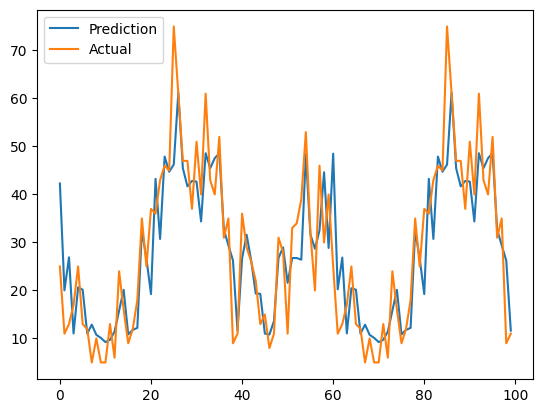

In [127]:
import matplotlib.pyplot as plt
start = 0
val_size = 200
x_test, y_test = create_dataset(tick_test[start:start + val_size], lookback=lookback)
# print(x.shape, y.shape)
# print(x[:10])
# print(y[:10])
model.eval()
with torch.no_grad():
    y_pred = model(x_test)

y_pred_np = y_pred.detach().numpy().squeeze()
y_actual_np = y_test.detach().numpy().squeeze()
print(y_pred_np[:5])
print(y_actual_np[:5])
# vals = 200

# plt.plot(X_train_1d[:vals], y_train_ds[:vals])
# plt.plot(X_train_1d[:vals], y_pred_np[:vals])
plt.plot(y_pred[:100], label='Prediction')
plt.plot(y_actual_np[:100], label='Actual')
plt.legend()

torch.Size([13332, 1, 1])


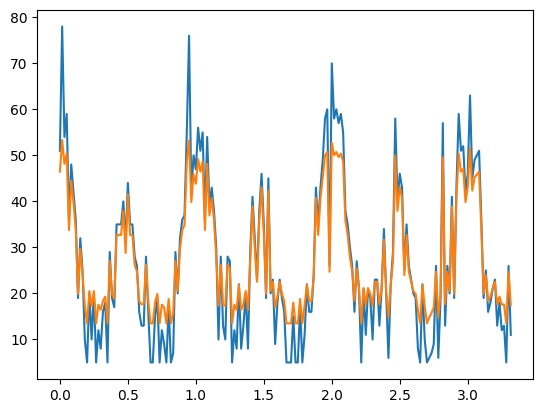

In [ ]:




plt.show()

# # print(y_test)

# x_test, y = create_dataset(y_test_vals, 1)

# print(x_test.size())
# print(x_test)


In [ ]:
diff = (y_test[:-1] - y_test_pred) ** 2
mse = np.mean(diff)
mse

29.45666465761544